<img src="https://raw.githubusercontent.com/euroargodev/argopy/master/docs/_static/argopy_logo_long.png" alt="argopy logo" width="200"/> 

# Scatter map with data mode of one BGC variable

This notebook shows how to:
- download BGC-Argo index
- search for profiles with a specific parameter
- export search results as a Pandas DataFrame
- extract data mode values for this parameter
- download info from Argo NVS Reference Tables about a parameter
- plot a map where profile locations are color coded with parameter data mode

In [1]:
from argopy import ArgoIndex  #  This is the class to work with Argo index content
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy.plot import scatter_map  # This is a function to easily make maps 

import numpy as np
from matplotlib import pyplot as plt

/Users/gmaze/miniconda3/envs/argopy-docs/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# Load an index of BGC profiles:
# idx = ArgoIndex(index_file='bgc-s').load()  # 'bgc-s' is a shortcut for 'argo_synthetic-profile_index.txt'
idx = ArgoIndex(index_file='bgc-b').load()  # 'bgc-b' is a shortcut for 'argo_bio-profile_index.txt'
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_bio-profile_index.txt
Convention: argo_bio-profile_index (Bio-Profile directory file of the Argo GDAC)
Loaded: True (289254 records)
Searched: False

In [3]:
# Define a parameter to work with:
# param = 'BBP470'
# param = 'DOXY'
param = 'BBP700'

In [4]:
# Get more verbose information about this parameter (usefull for plot titles):
reftbl = ArgoNVSReferenceTables().tbl('R03')
param_info = reftbl[reftbl['altLabel']==param].iloc[0]
param_info

altLabel                                                 BBP700
prefLabel             Particle backscattering at 700 nanometers
definition    Particle backscattering (/m) at 700 nm wavelen...
deprecated                                                false
id            http://vocab.nerc.ac.uk/collection/R03/current...
Name: 3, dtype: object

In [5]:
# Search for this parameter profiles:
idx.search_params(param)
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_bio-profile_index.txt
Convention: argo_bio-profile_index (Bio-Profile directory file of the Argo GDAC)
Loaded: True (289254 records)
Searched: True (116881 matches, 40.4077%)

In [6]:
# Possibly add a search in time (just to make a map more readable):
# idx.index = idx.search  # Trick to be able to chain multiple search methods with a single idx instance (new feature in dev to avoid this)
# idx.search_tim([-180,180,-90,90,'2023-01','2023-07'])
# idx

In [7]:
# Export search results to a dataframe:
df = idx.to_dataframe()
df.sample(5)

,file,date,latitude,longitude,ocean,profiler_code,institution_code,parameters,parameter_data_mode,date_update,wmo,cyc,institution,profiler
64561,coriolis/6901864/profiles/BD6901864_251.nc,2018-10-04 10:52:00,42.237,5.941,A,836,IF,PRES RAW_DOWNWELLING_IRRADIANCE380 RAW_DOWNWEL...,RRRRRRRRRRRRRDDDDRRRDRR,2022-07-29 09:32:00,6901864,251,"Ifremer, France",Unknown
55933,coriolis/6901581/profiles/BD6901581_157.nc,2015-12-22 05:45:00,-51.471,95.184,I,836,IF,PRES C1PHASE_DOXY C2PHASE_DOXY TEMP_DOXY C1PHA...,RRRRRRRRRRDRRRRRRRRRRRRDDDDRRRADRRRR,2022-07-28 13:00:47,6901581,157,"Ifremer, France",Unknown
47741,coriolis/6901480/profiles/BD6901480_324.nc,2016-07-17 15:37:00,59.700,-50.550,A,836,IF,PRES RAW_DOWNWELLING_IRRADIANCE380 RAW_DOWNWEL...,RRRRRRRRRRRRRDDDDRRRADR,2022-07-27 12:31:25,6901480,324,"Ifremer, France",Unknown
30265,aoml/5906310/profiles/BD5906310_018.nc,2021-07-02 22:35:41,-40.481,-151.127,P,863,AO,PRES TEMP_DOXY PHASE_DELAY_DOXY TEMP_VOLTAGE_D...,RRRRDRARARRRRRDRRD,2023-04-22 11:32:37,5906310,18,"AOML, USA",Navis-A float with SBE conductivity sensor
99320,csiro/5905167/profiles/BR5905167_365.nc,2017-06-24 13:50:22,-39.465,149.147,P,863,CS,PRES DOXY TEMP_DOXY PHASE_DELAY_DOXY TEMP_VOLT...,RARRRRRRRRRR,2023-03-01 11:38:27,5905167,365,"CSIRO, Australia",Navis-A float with SBE conductivity sensor


In [8]:
# To make the scatter map, we need to have the data mode available in one DataFrame column
# so we need to add a new column with the DATA_MODE of the PARAMETER:
df["variables"] = df["parameters"].apply(lambda x: x.split())
df["%s_DM" % param] = df.apply(lambda x: x['parameter_data_mode'][x['variables'].index(param)] if param in x['variables'] else '', axis=1)

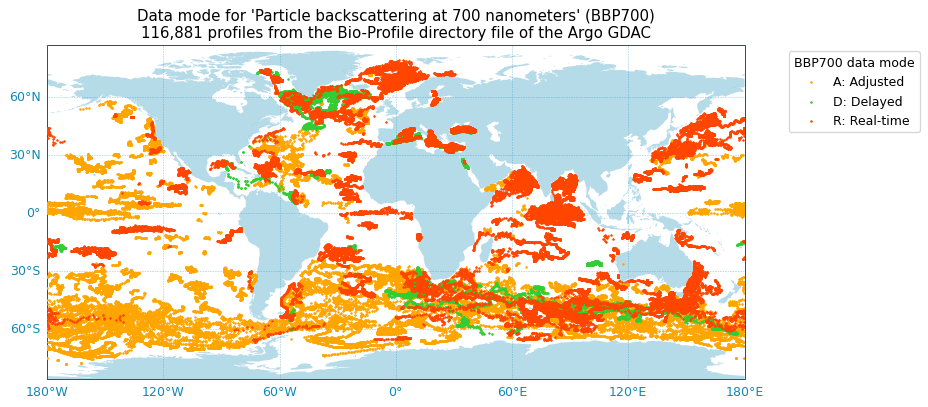

In [10]:
# Finally plot the map:
fig, ax = scatter_map(df,
                        hue="%s_DM" % param,
                        cmap="data_mode",
                        figsize=(10,6),
                        markersize=2,
                        markeredgecolor=None,
                        traj=False,  # Because some floats do weird things around 180/-180
                        set_global=False,
                        legend_title='%s data mode' % param)
ax.set_title("Data mode for '%s' (%s)\n%s profiles from the %s" % (param_info['prefLabel'], 
                                                                   param, 
                                                                   "{:,}".format(idx.N_MATCH), 
                                                                   idx.convention_title)
            );